In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange

2023-02-04 10:44:59.806574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 10:44:59.901192: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-04 10:44:59.924696: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-04 10:45:00.235740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
class Sharp_grad_X:
    def __init__(self,num_neuron, t_initial,t_final,k):
        self.num_neuron = num_neuron
        self.t0 = t_initial
        self.tfi = t_final
        self.k = k
    
        self.calculate_and_plot()
    
    def tune_hyper_parameters(self):
        '''
        Given the target number of neurons(num_neuron), the function we determine:
        * number of training point in the interval t_initial and t_final
        * the alpha and beta in the interval S_shape


        NB :make sure that the length of the interval is 1.
        '''
    

        num_trial_points = int(self.num_neuron/0.23)+1   #found imperically, tweak it as you please
        M = num_trial_points//2

        self.x = tf.cast(tf.linspace(self.t0,self.tfi,M)[:,None], tf.float32)

        value = int((num_trial_points - 10)/10) + 4
        # value = 10.

        uniform_int_alpha = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=1)
        uniform_int_beta = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=2)


        alpha = uniform_int_alpha(shape=(num_trial_points,))
        beta = uniform_int_beta(shape=(num_trial_points,))

        C = -beta/alpha


        good_alpha = []
        good_beta = []
        C_good = []
        counter = 0

        for i in tnrange(len(alpha)):
            value = (2.945)/alpha[i]
            low = C[i] - value
            high = C[i] + value

            if C[i] > self.x[0]  and C[i] <self.x[-1]:
                counter +=1
                good_alpha.append(alpha[i])
                good_beta.append(beta[i])
                C_good.append(C[i]) 

        return counter,good_alpha, good_beta      
        
    @staticmethod
    def sigma(x,alpha,beta):
        return 1./(1.+ tf.math.exp(-alpha*x -beta ))
    
    @staticmethod
    def S_matrices(x_m_minus_2,alpha,beta):
        with tf.autodiff.ForwardAccumulator(primals=x_m_minus_2,tangents=tf.ones_like(x_m_minus_2)) as outer:
            with tf.autodiff.ForwardAccumulator(primals=x_m_minus_2,tangents=tf.ones_like(x_m_minus_2)) as inner:
                S0 = Sharp_grad_X.sigma(x_m_minus_2,alpha,beta )
            S1 = inner.jvp(S0)
        S2 = outer.jvp(S1)  
        return S0,S1,S2

    @staticmethod
    def B_matrices(init_array,alpha,beta):
    #     xk = tf.constant(init_array,dtype=tf.float32)
        xk = init_array
        with tf.autodiff.ForwardAccumulator(primals=xk,tangents=tf.ones_like(xk)) as tape:
            B0 = Sharp_grad_X.sigma(xk,alpha,beta )
        B1 = tape.jvp(B0)
        return B0,B1
    
    def calculate_and_plot(self):
        neurons,good_alpha, good_beta   = self.tune_hyper_parameters()
        print(f'neurons :{neurons}')
        M = neurons//2
        alpha = tf.convert_to_tensor(good_alpha,tf.float32)
        beta = tf.convert_to_tensor(good_beta,tf.float32)
        self.x = tf.cast(tf.linspace(self.t0,self.tfi,M)[:,None], tf.float32)
        
        x_m_minus_2 = tf.linspace(self.x[1],self.x[-2],M-2)
        k = self.k
        S0,S1,S2 = self.S_matrices(x_m_minus_2,alpha,beta)
        int_array = tf.concat([self.x[0],self.x[-1]],axis=0)[:,None]
        B0,B1 = Sharp_grad_X.B_matrices(int_array,alpha,beta)

        fg = np.zeros((M,1))
        SB_matrix = np.zeros((M,neurons))
        lhs_eqn = S2 + (4.*tf.pow(k*np.pi,2) - 1.)*S0
        rhs_eqn = 4.*k*np.pi*tf.math.exp(x_m_minus_2)*tf.math.cos(2.*k*np.pi*x_m_minus_2)

        lhs_BC =  B0
        rhs_BC =  tf.zeros((2,1))
        # 

        # First row == B0[0]
        SB_matrix[0] = lhs_BC[0]
        # Last row == B0[-1]
        SB_matrix[-1] = lhs_BC[-1]
        # inbetween == rhs_eqn
        SB_matrix[1:-1] = lhs_eqn

        # FG matrix
        # First row == B0[0]
        fg[0] = rhs_BC[0]
        # Last row == B0[-1]
        fg[-1] = rhs_BC[-1]
        # inbetween == rhs_eqn
        fg[1:-1] = rhs_eqn

        weight = tf.linalg.pinv(SB_matrix)@fg
        weight = tf.cast(weight, tf.float32)
        u_hat = Sharp_grad_X.sigma(self.x, alpha, beta)@weight
        u = lambda x: tf.math.exp(x)*tf.math.sin(2.*k*np.pi*x)
        error = tf.norm(u_hat- u(self.x))
        mse = tf.reduce_mean(tf.square(u_hat- u(self.x)))
        residue = SB_matrix@weight - fg
        res_nrom = tf.norm(residue)
        res_mse = tf.reduce_mean(tf.square(residue))
        print(f'Residue Norm  : {res_nrom}')
        print(f'Residue mse  : {res_mse}')
        print(f'Error : {tf.norm(error)}') 
        print(f'mse Error  : {mse}')
        plt.plot(self.x,u(self.x))
        plt.plot(self.x,u_hat, 'r--')
        # plt.xlim(0.4)
        # plt.ylim(-50.,50.)
        plt.show()              


2023-02-04 10:45:03.211524: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-02-04 10:45:03.211548: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tshegofatso-GE76-Raider-11UG
2023-02-04 10:45:03.211552: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tshegofatso-GE76-Raider-11UG
2023-02-04 10:45:03.211658: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2023-02-04 10:45:03.211668: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2023-02-04 10:45:03.211672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2023-02-04 10:45:03.212369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following 

  0%|          | 0/587 [00:00<?, ?it/s]

neurons :135
Residue Norm  : 0.010990451090037823
Residue mse  : 1.802836095521343e-06
Error : 0.38038381934165955
mse Error  : 0.0021595798898488283


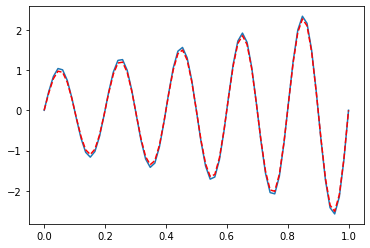

In [3]:
num_neuron, t_initial,t_final,k = 135, 0.,1.,5
test = Sharp_grad_X(num_neuron, t_initial,t_final,k)

In [54]:
t0 = 0.
tfi = 1.

num_trial_points = int(1120/0.23)+1   #found imperically, tweak it as you please
M = num_trial_points//2

x = tf.cast(tf.linspace(t0,tfi,M)[:,None], tf.float32)

value = int((num_trial_points - 10)/10) + 4
# value = 10.

uniform_int_alpha = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=1)
uniform_int_beta = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=2)


alpha = uniform_int_alpha(shape=(num_trial_points,))
beta = uniform_int_beta(shape=(num_trial_points,))

C = -beta/alpha


good_alpha = []
good_beta = []
C_good = []
counter = 0

for i in tnrange(len(alpha)):
    value = (2.945)/alpha[i]
    low = C[i] - value
    high = C[i] + value

    for alpha[i]>0.:
        if C[i] > x[0]  and C[i] <x[-1]:
            counter +=1
            good_alpha.append(alpha[i])
            good_beta.append(beta[i])
            C_good.append(C[i]) 

            print(f'sigma :{sigma(x,alpha[i], beta[i])[-1]}')
    #         print(f'Distance I.:{distance_I}')
    #         print(f'Distance x.:{distance_x}')
            print(f'Is close :{np.isclose(sigma(C[i],alpha[i], beta[i]),0.5)}')
            print(f'high value:{high}')
            plt.plot(x,sigma(x,alpha[i], beta[i]))
            plt.hlines(y = sigma(C[i],alpha[i], beta[i]),xmin= low, xmax=high, colors='red', linestyles='-')
            plt.vlines(x = C[i], ymin=0.04, ymax= 1.,colors='b', linestyles='-')
            plt.vlines(x = low, ymin=0.04, ymax= 1.,colors='g', linestyles='--')
            plt.vlines(x = high, ymin=0.04, ymax= 1.,colors='g', linestyles='--')        

            plt.title(f' i :{i}  C:{C[i]} a :{alpha[i]} b {beta[i]}')
            plt.show()


SyntaxError: invalid syntax (1012273486.py, line 32)

In [36]:
tf.reduce_max(C_good)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9980841>

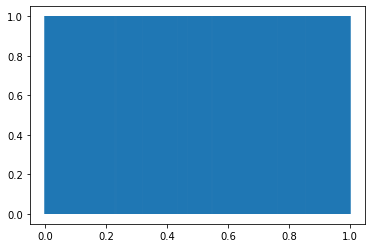

In [49]:
plt.vlines(C_good, ymin=0.00,ymax=1.)

In [52]:
alpha[alpha>0]

<tf.Tensor: shape=(617,), dtype=float32, numpy=
array([311.03748 , 411.95953 , 169.33423 , 284.18115 , 418.16132 ,
       469.9325  , 416.83862 , 179.95764 , 428.11353 , 433.94135 ,
       484.94403 , 276.40338 , 195.50012 , 306.60645 , 375.85767 ,
       252.27356 , 431.62964 , 325.87952 , 166.53021 , 372.01508 ,
       201.48975 , 362.78503 , 287.02325 , 323.17377 , 347.31604 ,
       308.22296 , 458.5495  , 223.64154 , 383.69806 , 160.32562 ,
       259.1903  , 331.0202  , 275.56775 , 283.3817  , 371.78162 ,
       155.7406  , 235.05353 , 418.59418 , 142.02777 , 320.2301  ,
       152.67603 , 457.80066 , 281.83496 , 375.70966 , 407.3468  ,
       378.35327 , 314.10272 , 166.50171 , 456.32666 , 141.737   ,
       347.77618 , 280.41388 , 319.60565 ,  78.128784, 372.7846  ,
       154.97797 , 236.70111 , 237.71442 , 326.21973 , 363.22937 ,
       394.40308 , 271.99524 , 373.50012 , 282.07208 , 427.76227 ,
       251.63977 , 345.99402 , 333.70715 , 487.82086 , 212.9649  ,
       418.875

In [4]:
def tune_hyper_parameters(num_neuron, t0,tfi):
    '''
    Given the target number of neurons(num_neuron), the function we determine:
    * number of training point in the interval t_initial and t_final
    * the alpha and beta in the interval S_shape
    
    
    NB :make sure that the length of the interval is 1.
    '''
    
    
    num_trial_points = int(num_neuron/0.23)+1   #found imperically, tweak it as you please
    M = num_trial_points//2

    x = tf.cast(tf.linspace(t0,tfi,M)[:,None], tf.float32)

    value = int((num_trial_points - 10)/10) + 4
    # value = 10.

    uniform_int_alpha = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=1)
    uniform_int_beta = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=2)


    alpha = uniform_int_alpha(shape=(num_trial_points,))
    beta = uniform_int_beta(shape=(num_trial_points,))

    C = -beta/alpha
    
    
    good_alpha = []
    good_beta = []
    C_good = []
    counter = 0
    
    for i in tnrange(len(alpha)):
        value = (2.945)/alpha[i]
        low = C[i] - value
        high = C[i] + value
        
        if C[i] > x[0]  and C[i] <x[-1]:
            counter +=1
            good_alpha.append(alpha[i])
            good_beta.append(beta[i])
            C_good.append(C[i]) 
            
    return counter,good_alpha, good_beta  

In [7]:
# t0 = 0.
# tfi = 1.
# tf.function(tune_hyper_parameters)(5, t0,tfi)

In [34]:
t0 = 0.
tfi = 1.
neurons,good_alpha, good_beta   = tune_hyper_parameters(1120, t0,tfi)
print(f'neurons :{neurons}')
M = neurons//2
print(f'M :{M}')
x = tf.cast(tf.linspace(t0,tfi,M)[:,None], tf.float32)
print(f'x :{x.shape}')
alpha = tf.convert_to_tensor(good_alpha,tf.float32)
beta = tf.convert_to_tensor(good_beta,tf.float32)

x_m_minus_2 = tf.linspace(x[1],x[-2],M-2)
S_matrices(x_m_minus_2,alpha,beta)

  0%|          | 0/4870 [00:00<?, ?it/s]

neurons :1201
M :600
x :(600, 1)


(<tf.Tensor: shape=(598, 1201), dtype=float32, numpy=
 array([[6.4570628e-35, 1.0000000e+00, 1.2550170e-03, ..., 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00],
        [1.0852888e-34, 1.0000000e+00, 2.4934169e-03, ..., 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00],
        [1.8241430e-34, 1.0000000e+00, 4.9477629e-03, ..., 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00],
        ...,
        [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 4.8904197e-34,
         1.4223022e-13, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 4.1673258e-34,
         9.7504524e-14, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 3.5511480e-34,
         6.6843266e-14, 0.0000000e+00]], dtype=float32)>,
 <tf.Tensor: shape=(598, 1201), dtype=float32, numpy=
 array([[ 0.0000000e+00, -2.4992919e-16,  5.1636732e-01, ...,
         -8.8185760e-07,  0.0000000e+00, -7.2249097e-27],
        [ 0.0000000e+00, -3.9141001e-16,  1.0246257e+00, 

In [33]:
def S_matrices(x,alpha,beta):
    with tf.autodiff.ForwardAccumulator(primals=x,tangents=tf.ones_like(x)) as outer:
        with tf.autodiff.ForwardAccumulator(primals=x,tangents=tf.ones_like(x)) as inner:
            S0 = sigma(x,alpha,beta )
        S1 = inner.jvp(S0)
    S2 = outer.jvp(S1)  
    return S0,S1,S2

In [20]:
S_matrices(x_m_minus_2,alpha,beta)

<tf.Tensor: shape=(598, 1201), dtype=float32, numpy=
array([[           nan,  6.7155848e-14, -2.1218848e+02, ...,
         8.4521293e-05,  0.0000000e+00,  1.2701884e-24],
       [           nan,  1.0517167e-13, -4.1999933e+02, ...,
         9.9187397e-05,  0.0000000e+00,  1.7034584e-24],
       [           nan,  1.6470823e-13, -8.2726556e+02, ...,
         1.1639836e-04,  0.0000000e+00,  2.2845368e-24],
       ...,
       [ 0.0000000e+00,            nan,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,            nan],
       [ 0.0000000e+00,            nan,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,            nan],
       [ 0.0000000e+00,            nan,  0.0000000e+00, ...,
        -0.0000000e+00, -0.0000000e+00,            nan]], dtype=float32)>

In [21]:
x_m_minus_2

<tf.Tensor: shape=(598, 1), dtype=float32, numpy=
array([[0.00166945],
       [0.0033389 ],
       [0.00500835],
       [0.0066778 ],
       [0.00834724],
       [0.01001669],
       [0.01168614],
       [0.01335559],
       [0.01502504],
       [0.01669449],
       [0.01836394],
       [0.02003339],
       [0.02170284],
       [0.02337229],
       [0.02504174],
       [0.02671118],
       [0.02838063],
       [0.03005008],
       [0.03171953],
       [0.03338898],
       [0.03505843],
       [0.03672788],
       [0.03839733],
       [0.04006677],
       [0.04173623],
       [0.04340567],
       [0.04507512],
       [0.04674457],
       [0.04841402],
       [0.05008347],
       [0.05175292],
       [0.05342237],
       [0.05509182],
       [0.05676126],
       [0.05843072],
       [0.06010016],
       [0.06176961],
       [0.06343906],
       [0.06510852],
       [0.06677797],
       [0.06844741],
       [0.07011686],
       [0.07178631],
       [0.07345576],
       [0.07512521],
     

In [13]:
alpha = tf.convert_to_tensor(good_alpha,tf.float32)
beta = tf.convert_to_tensor(good_beta,tf.float32)

x_m_minus_2 = tf.linspace(x[1],x[-2],M-2)
k = 5.
# S0,S1,S2 = S_matrices(x_m_minus_2,alpha,beta)
int_array = tf.concat([x[0],x[-1]],axis=0)[:,None]
#     B0,B1 = B_matrices(int_array,alpha,beta)

fg = np.zeros((M,1))
SB_matrix = np.zeros((M,neurons))

lhs_eqn = lhs_or_eqn(x_m_minus_2,alpha,beta)
rhs_eqn = rhs_or_eqn(x_m_minus_2)

lhs_BC =  lhs_bc(int_array,alpha,beta)
rhs_BC =  rhs_bc(int_array)
# 

# First row == B0[0]
SB_matrix[0] = lhs_BC[0]
# Last row == B0[-1]
SB_matrix[-1] = lhs_BC[-1]
# inbetween == rhs_eqn
SB_matrix[1:-1] = lhs_eqn

# FG matrix
# First row == B0[0]
fg[0] = rhs_BC[0]
# Last row == B0[-1]
fg[-1] = rhs_BC[-1]
# inbetween == rhs_eqn
fg[1:-1] = rhs_eqn

weight = tf.linalg.pinv(SB_matrix)@fg
weight = tf.cast(weight, tf.float32)
u_hat = sigma(x, alpha, beta)@weight
# u_hat

2023-02-04 07:47:56.401833: E ./tensorflow/core/kernels/linalg/svd_op_impl.h:110] Eigen::BDCSVD failed with error code 3


In [14]:
tf.linalg.pinv(SB_matrix)

2023-02-04 07:48:04.749015: E ./tensorflow/core/kernels/linalg/svd_op_impl.h:110] Eigen::BDCSVD failed with error code 3


<tf.Tensor: shape=(1201, 600), dtype=float64, numpy=
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])>

In [23]:
def S_matrices(x,alpha,beta):
    with tf.autodiff.ForwardAccumulator(primals=x,tangents=tf.ones_like(x)) as outer:
        with tf.autodiff.ForwardAccumulator(primals=x,tangents=tf.ones_like(x)) as inner:
            S0 = sigma(x,alpha,beta )
        S1 = inner.jvp(S0)
    S2 = outer.jvp(S1)  
    return S0,S1,S2

In [27]:
S0

<tf.Tensor: shape=(600, 1201), dtype=float32, numpy=
array([[3.8416826e-35, 1.0000000e+00, 6.3130120e-04, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [6.4570628e-35, 1.0000000e+00, 1.2550170e-03, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [1.0852888e-34, 1.0000000e+00, 2.4934169e-03, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       ...,
       [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 4.1673258e-34,
        9.7504524e-14, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 3.5511480e-34,
        6.6843266e-14, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 3.0260544e-34,
        4.5823042e-14, 0.0000000e+00]], dtype=float32)>

In [24]:
S_matrices(x,alpha,beta)

(<tf.Tensor: shape=(600, 1201), dtype=float32, numpy=
 array([[3.8416826e-35, 1.0000000e+00, 6.3130120e-04, ..., 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00],
        [6.4570628e-35, 1.0000000e+00, 1.2550170e-03, ..., 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00],
        [1.0852888e-34, 1.0000000e+00, 2.4934169e-03, ..., 1.0000000e+00,
         1.0000000e+00, 1.0000000e+00],
        ...,
        [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 4.1673258e-34,
         9.7504524e-14, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 3.5511480e-34,
         6.6843266e-14, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 3.0260544e-34,
         4.5823042e-14, 0.0000000e+00]], dtype=float32)>,
 <tf.Tensor: shape=(600, 1201), dtype=float32, numpy=
 array([[ 0.0000000e+00, -1.5958807e-16,  2.5990635e-01, ...,
         -7.5146392e-07,  0.0000000e+00, -5.3872328e-27],
        [ 0.0000000e+00, -2.4992919e-16,  5.1636732e-01, 

In [22]:
sigma = lambda x,alpha,beta : 1./(1.+ tf.math.exp(-alpha*x -beta ))

eps = 1./(10.*np.pi)

def S_matrices(x,alpha,beta):
    with tf.autodiff.ForwardAccumulator(primals=x,tangents=tf.ones_like(x)) as outer:
        with tf.autodiff.ForwardAccumulator(primals=x,tangents=tf.ones_like(x)) as inner:
            S0 = sigma(x,alpha,beta )
        S1 = inner.jvp(S0)
    S2 = outer.jvp(S1)  
    return S0,S1,S2


def B_matrices(init_array,alpha,beta):
#     xk = tf.constant(init_array,dtype=tf.float32)
    xk = init_array
    with tf.autodiff.ForwardAccumulator(primals=xk,tangents=tf.ones_like(xk)) as tape:
        B0 = sigma(xk,alpha,beta )
    B1 = tape.jvp(B0)
    return B0,B1

def u(x):
    return tf.math.sin(1./(eps+x))

def rhs_or_eqn(x):
    num = 2.*(eps+x)*tf.math.cos(1./(eps+x))-tf.math.sin(1./(eps+x))
    deno = tf.pow((eps+x),4)
    return -num/deno
#     return 4.*k*np.pi*tf.math.exp(x)*tf.math.cos(2.*k*np.pi*x)

def lhs_or_eqn(x,alpha,beta):
    S0,S1,S2 = S_matrices(x,alpha,beta)
    return -S2
#     return S2 + (4.*tf.pow(k*np.pi,2) - 1.)*S0

def lhs_bc(x0,alpha,beta):
    B0,B1 = B_matrices(x0,alpha,beta)
    return B0

def rhs_bc(x0):
    return u(x0)
    
    

def calculate_and_plot(num_neuron, t0,tfi):
    neurons,good_alpha, good_beta   = tune_hyper_parameters(num_neuron, t0,tfi)
    print(f'neurons :{neurons}')
    M = neurons//2
    x = tf.cast(tf.linspace(t0,tfi,M)[:,None], tf.float32)
    alpha = tf.convert_to_tensor(good_alpha,tf.float32)
    beta = tf.convert_to_tensor(good_beta,tf.float32)

    x_m_minus_2 = tf.linspace(x[1],x[-2],M-2)
    k = 5.
    S0,S1,S2 = S_matrices(x_m_minus_2,alpha,beta)
    int_array = tf.concat([x[0],x[-1]],axis=0)[:,None]
#     B0,B1 = B_matrices(int_array,alpha,beta)

    fg = np.zeros((M,1))
    SB_matrix = np.zeros((M,neurons))
    
    lhs_eqn = lhs_or_eqn(x_m_minus_2,alpha,beta)
    rhs_eqn = rhs_or_eqn(x_m_minus_2)

    lhs_BC =  lhs_bc(int_array,alpha,beta)
    rhs_BC =  rhs_bc(int_array)
    # 

    # First row == B0[0]
    SB_matrix[0] = lhs_BC[0]
    # Last row == B0[-1]
    SB_matrix[-1] = lhs_BC[-1]
    # inbetween == rhs_eqn
    SB_matrix[1:-1] = lhs_eqn

    # FG matrix
    # First row == B0[0]
    fg[0] = rhs_BC[0]
    # Last row == B0[-1]
    fg[-1] = rhs_BC[-1]
    # inbetween == rhs_eqn
    fg[1:-1] = rhs_eqn

    weight = tf.linalg.pinv(SB_matrix)@fg
    weight = tf.cast(weight, tf.float32)
    u_hat = sigma(x, alpha, beta)@weight
#     u = lambda x: tf.math.exp(x)*tf.math.sin(2.*k*np.pi*x)
    error = tf.norm(u_hat- u(x))
    mse = tf.reduce_mean(tf.square(u_hat- u(x)))
    residue = SB_matrix@weight - fg
    res_nrom = tf.norm(residue)
    res_mse = tf.reduce_mean(tf.square(residue))
    print(f'Residue Norm  : {res_nrom}')
    print(f'Residue mse  : {res_mse}')
    print(f'Error : {tf.norm(error)}') 
    print(f'mse Error  : {mse}')
    plt.plot(x,u(x))
    plt.plot(x,u_hat, 'r--')
    # plt.xlim(0.4)
    # plt.ylim(-50.,50.)
    plt.show()              

  0%|          | 0/5566 [00:00<?, ?it/s]

neurons :1374
Residue Norm  : nan
Residue mse  : nan
Error : nan
mse Error  : nan


2023-02-04 07:36:50.125637: E ./tensorflow/core/kernels/linalg/svd_op_impl.h:110] Eigen::BDCSVD failed with error code 3


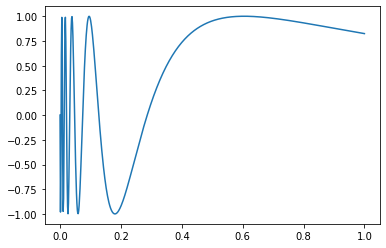

In [60]:
calculate_and_plot(1280, 0.,1.)

In [5]:
neurons = int(160/0.23)+1
M = neurons//2

x = tf.cast(tf.linspace(0,1,M)[:,None], tf.float32)

value = int((neurons - 10)/10) + 4
# value = 10.

uniform_int_alpha = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=1)
uniform_int_beta = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=2)


alpha = uniform_int_alpha(shape=(neurons,))
beta = uniform_int_beta(shape=(neurons,))

C = -beta/alpha

In [6]:
M

348

In [31]:
def calc_alpha_beta(alpha,beta,C):
    good_alpha = []
    good_beta = []
    C_good = []
    counter = 0
    
    for i in tnrange(len(alpha)):
        value = (2.945)/alpha[i]
        low = C[i] - value
        high = C[i] + value
        
        if C[i] > x[0]  and C[i] <x[-1]:
            counter +=1
            good_alpha.append(alpha[i])
            good_beta.append(beta[i])
            C_good.append(C[i]) 
            
    return counter,good_alpha, good_beta   

  0%|          | 0/696 [00:00<?, ?it/s]

neurons :159
Residue Norm  : 0.008300688117742538
Residue mse  : 8.72169948706869e-07
Error : 0.29059216380119324
mse Error  : 0.0002426545979687944


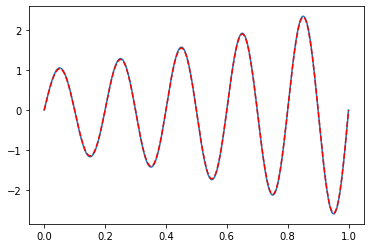

In [33]:
counter,good_alpha, good_beta  = calc_alpha_beta(alpha,beta,C)
neurons = len(good_beta)
print(f'neurons :{neurons}')
M = neurons//2
alpha = tf.convert_to_tensor(good_alpha,tf.float32)
beta = tf.convert_to_tensor(good_beta,tf.float32)

x_m_minus_2 = tf.linspace(x[1],x[-2],M-2)
k = 5.
S0,S1,S2 = S_matrices(x_m_minus_2,alpha,beta)
int_array = tf.concat([x[0],x[-1]],axis=0)[:,None]
B0,B1 = B_matrices(int_array,alpha,beta)

fg = np.zeros((M,1))
SB_matrix = np.zeros((M,neurons))
lhs_eqn = S2 + (4.*tf.pow(k*np.pi,2) - 1.)*S0
rhs_eqn = 4.*k*np.pi*tf.math.exp(x_m_minus_2)*tf.math.cos(2.*k*np.pi*x_m_minus_2)

lhs_BC =  B0
rhs_BC =  tf.zeros((2,1))
# 

# First row == B0[0]
SB_matrix[0] = lhs_BC[0]
# Last row == B0[-1]
SB_matrix[-1] = lhs_BC[-1]
# inbetween == rhs_eqn
SB_matrix[1:-1] = lhs_eqn

# FG matrix
# First row == B0[0]
fg[0] = rhs_BC[0]
# Last row == B0[-1]
fg[-1] = rhs_BC[-1]
# inbetween == rhs_eqn
fg[1:-1] = rhs_eqn

weight = tf.linalg.pinv(SB_matrix)@fg
weight = tf.cast(weight, tf.float32)
u_hat = sigma(x, alpha, beta)@weight
u = lambda x: tf.math.exp(x)*tf.math.sin(2.*k*np.pi*x)
error = tf.norm(u_hat- u(x))
mse = tf.reduce_mean(tf.square(u_hat- u(x)))
residue = SB_matrix@weight - fg
res_nrom = tf.norm(residue)
res_mse = tf.reduce_mean(tf.square(residue))
print(f'Residue Norm  : {res_nrom}')
print(f'Residue mse  : {res_mse}')
print(f'Error : {tf.norm(error)}') 
print(f'mse Error  : {mse}')
plt.plot(x,u(x))
plt.plot(x,u_hat, 'r--')
# plt.xlim(0.4)
# plt.ylim(-50.,50.)
plt.show()              

  0%|          | 0/500 [00:00<?, ?it/s]

sigma :[1.]
Distance I.:0.3809804618358612
Distance x.:1.0
C :0.25477495789527893


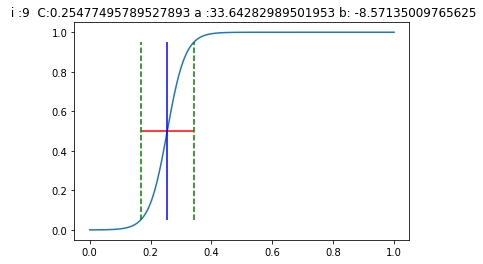

sigma :[2.23529e-11]
Distance I.:0.26329606771469116
Distance x.:1.0
C :0.1561877280473709


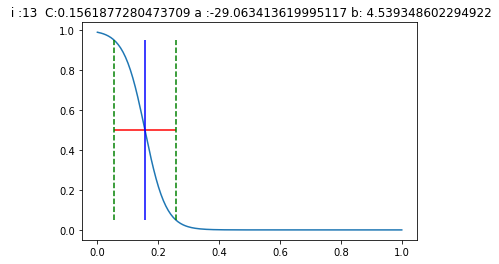

sigma :[1.]
Distance I.:0.09682973474264145
Distance x.:1.0
C :0.017883121967315674


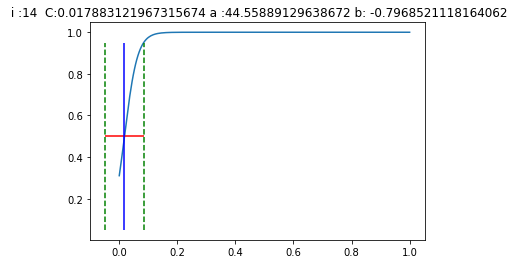

sigma :[0.00023215]
Distance I.:0.4826633036136627
Distance x.:1.0
C :0.03551105782389641


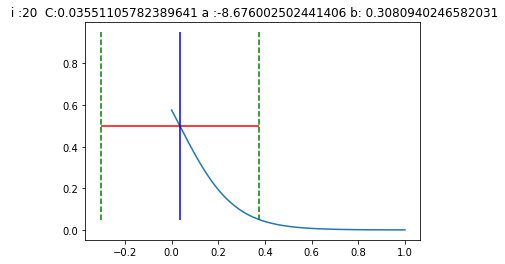

sigma :[0.989027]
Distance I.:1.090624451637268
Distance x.:1.0
C :0.7542394995689392


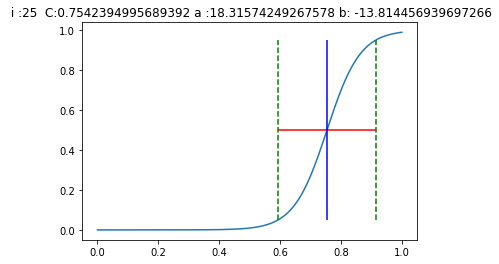

sigma :[0.6986014]
Distance I.:1.3821938037872314
Distance x.:1.0
C :0.9726511836051941


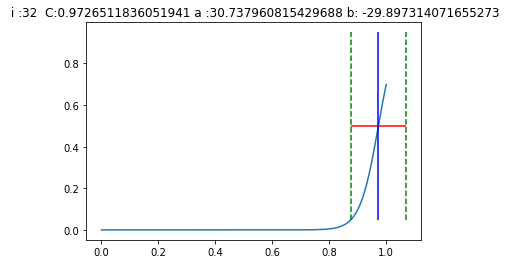

sigma :[3.6834131e-09]
Distance I.:0.8731616735458374
Distance x.:1.0
C :0.6146466135978699


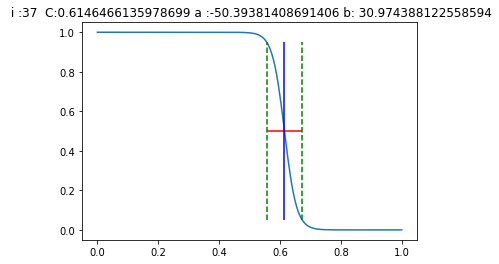

sigma :[1.]
Distance I.:0.5681585073471069
Distance x.:1.0
C :0.39643722772598267


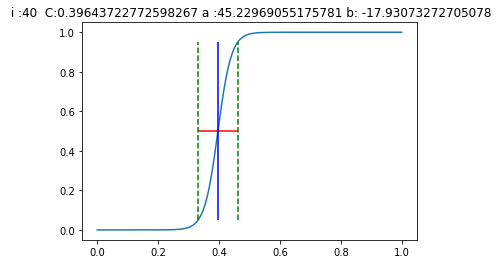

sigma :[0.9999907]
Distance I.:1.094989538192749
Distance x.:1.0
C :0.7721036672592163


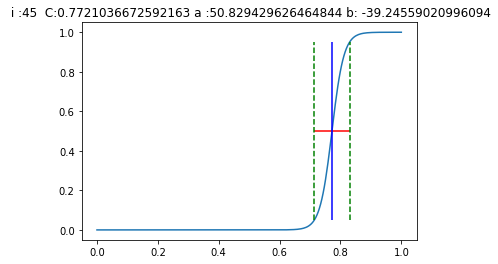

sigma :[1.]
Distance I.:0.18567568063735962
Distance x.:1.0
C :0.11389115452766418


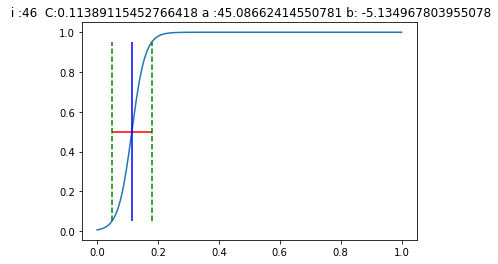

sigma :[0.99999535]
Distance I.:0.5639894604682922
Distance x.:1.0
C :0.3689861297607422


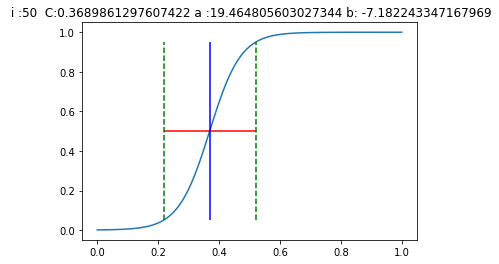

sigma :[1.]
Distance I.:0.49921560287475586
Distance x.:1.0
C :0.34722232818603516


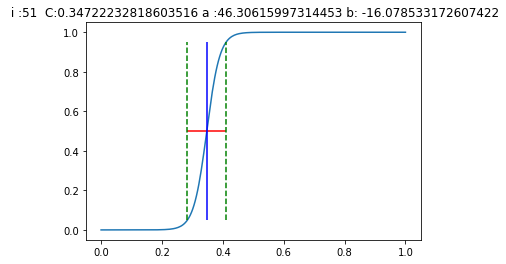

sigma :[2.645016e-19]
Distance I.:0.11573920398950577
Distance x.:1.0
C :0.049113236367702484


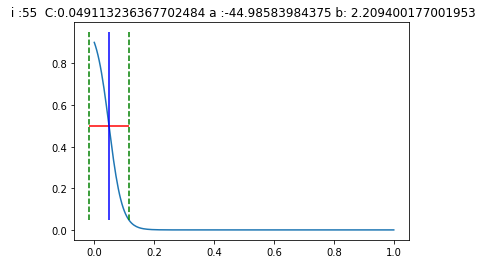

sigma :[0.9999999]
Distance I.:0.9235386848449707
Distance x.:1.0
C :0.6500192284584045


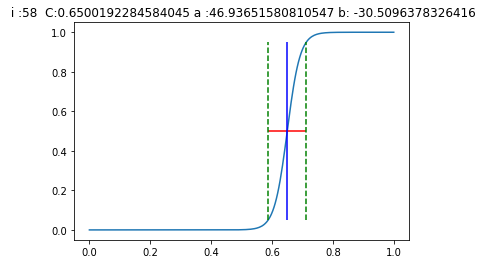

sigma :[0.9999999]
Distance I.:0.9695810079574585
Distance x.:1.0
C :0.6832944750785828


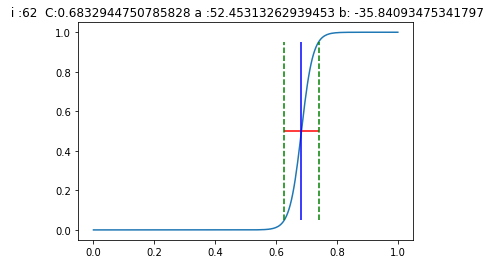

sigma :[1.]
Distance I.:0.1507551372051239
Distance x.:1.0
C :0.04074495658278465


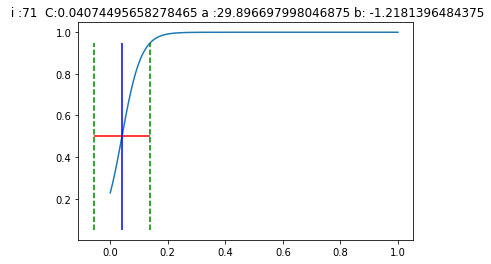

sigma :[9.5081494e-05]
Distance I.:0.8519173860549927
Distance x.:1.0
C :0.5879736542701721


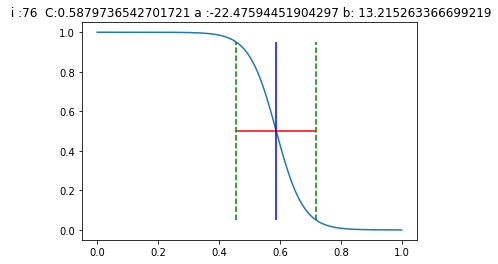

sigma :[0.9999995]
Distance I.:0.4851396381855011
Distance x.:1.0
C :0.31350284814834595


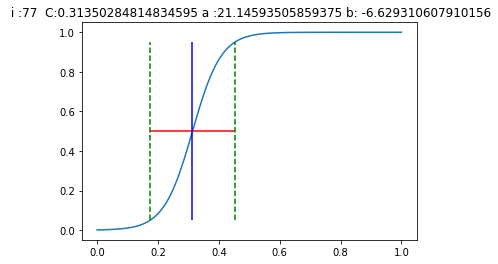

sigma :[3.4986133e-12]
Distance I.:0.4718972444534302
Distance x.:1.0
C :0.3250623643398285


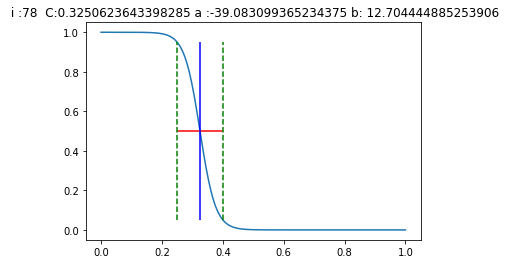

sigma :[0.7547088]
Distance I.:1.3720465898513794
Distance x.:1.0
C :0.9661108255386353


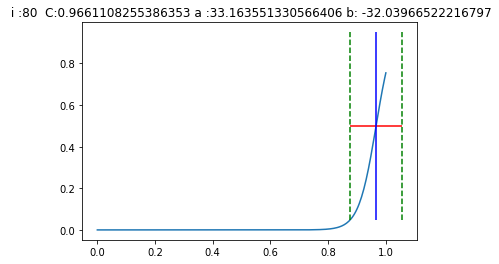

sigma :[8.088336e-07]
Distance I.:1.007242202758789
Distance x.:1.0
C :0.7096138000488281


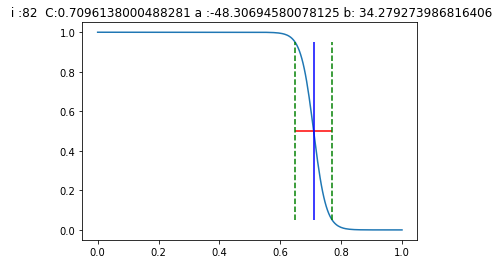

sigma :[2.4598562e-06]
Distance I.:0.7403854727745056
Distance x.:1.0
C :0.5115469098091125


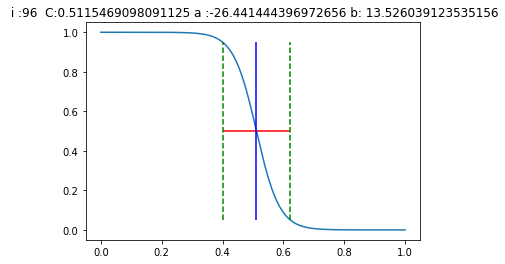

sigma :[1.]
Distance I.:0.1479586660861969
Distance x.:1.0
C :0.07548671215772629


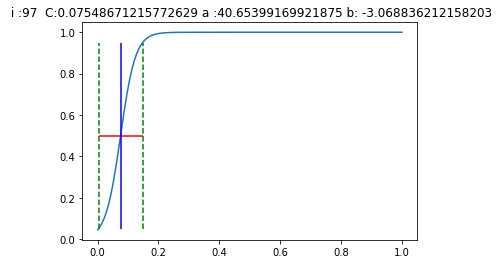

sigma :[1.]
Distance I.:0.5444520711898804
Distance x.:1.0
C :0.36954784393310547


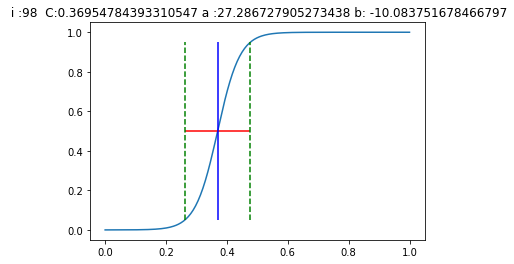

sigma :[2.8640992e-11]
Distance I.:0.2506055533885956
Distance x.:1.0
C :0.14355070888996124


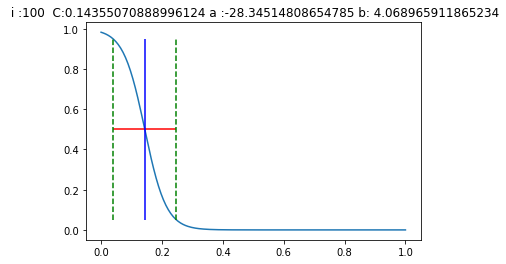

sigma :[1.]
Distance I.:0.8562390804290771
Distance x.:1.0
C :0.6021574139595032


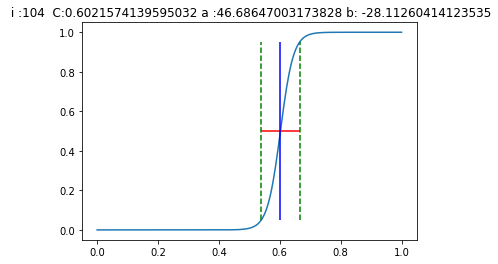

sigma :[0.9999999]
Distance I.:0.797877311706543
Distance x.:1.0
C :0.5579636693000793


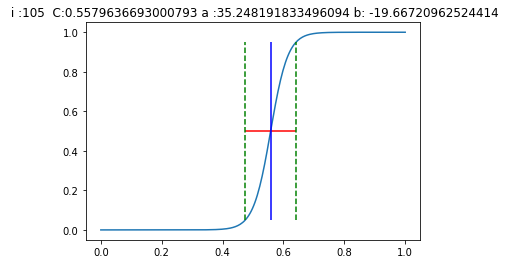

sigma :[0.99999976]
Distance I.:0.32880258560180664
Distance x.:1.0
C :0.16529962420463562


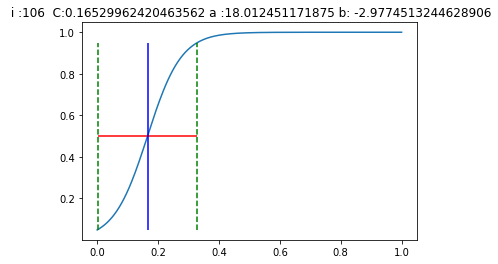

sigma :[0.9496252]
Distance I.:1.315084457397461
Distance x.:1.0
C :0.9270204901695251


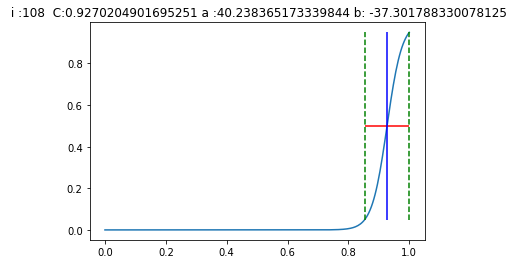

sigma :[0.9999902]
Distance I.:0.6923287510871887
Distance x.:1.0
C :0.4705309569835663


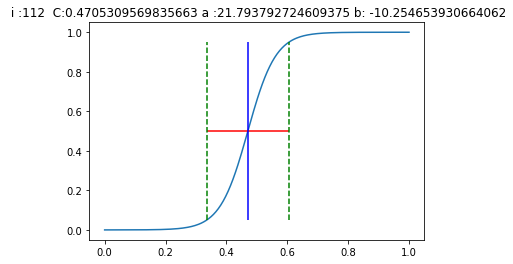

sigma :[8.286731e-13]
Distance I.:0.29889363050460815
Distance x.:1.0
C :0.19332902133464813


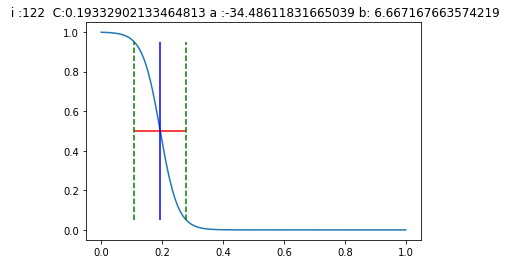

sigma :[0.14650317]
Distance I.:1.3011051416397095
Distance x.:1.0
C :0.9067177772521973


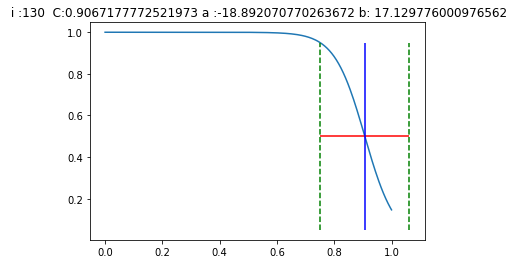

sigma :[4.159602e-14]
Distance I.:0.1658758521080017
Distance x.:1.0
C :0.0773274153470993


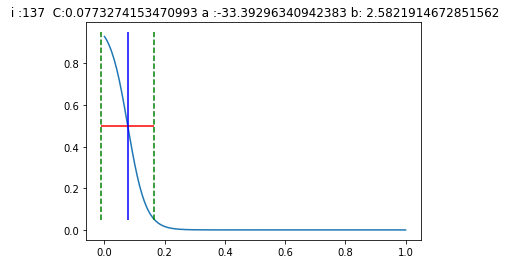

sigma :[0.760436]
Distance I.:1.376682162284851
Distance x.:1.0
C :0.9705639481544495


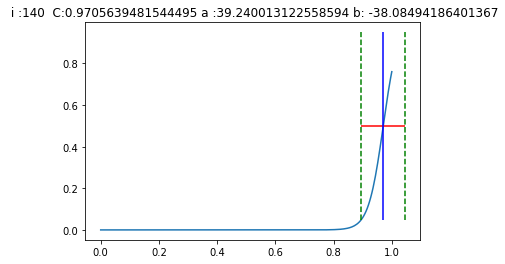

sigma :[0.99109334]
Distance I.:1.207045316696167
Distance x.:1.0
C :0.8482219576835632


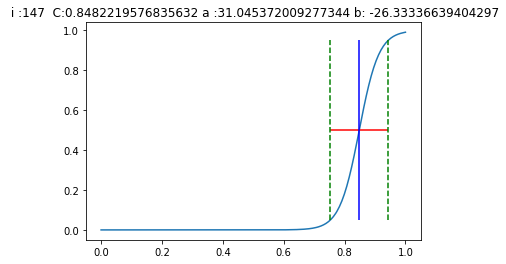

sigma :[0.99996316]
Distance I.:1.0082693099975586
Distance x.:1.0
C :0.7079586982727051


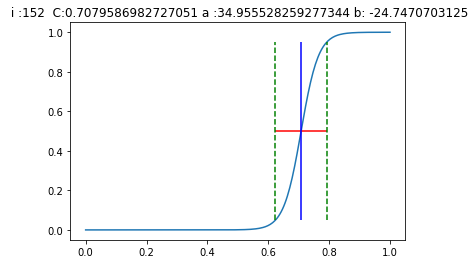

sigma :[0.0226869]
Distance I.:0.9037876725196838
Distance x.:1.0
C :0.5129625201225281


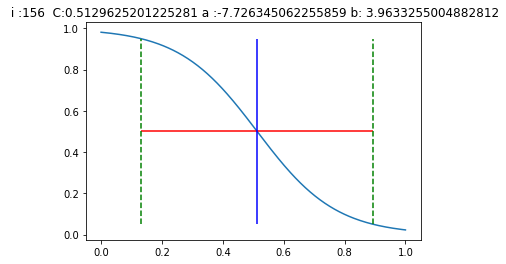

sigma :[1.]
Distance I.:0.32129231095314026
Distance x.:1.0
C :0.21323417127132416


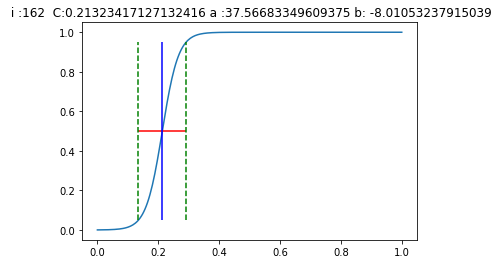

sigma :[3.4716152e-10]
Distance I.:0.5919846296310425
Distance x.:1.0
C :0.4109497368335724


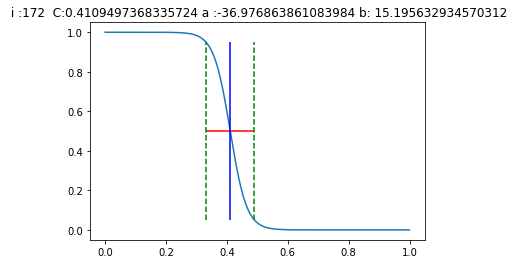

sigma :[1.]
Distance I.:0.12588490545749664
Distance x.:1.0
C :0.010961544699966908


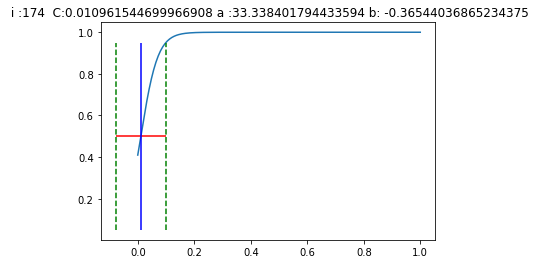

sigma :[0.00051643]
Distance I.:0.8366979360580444
Distance x.:1.0
C :0.5671514272689819


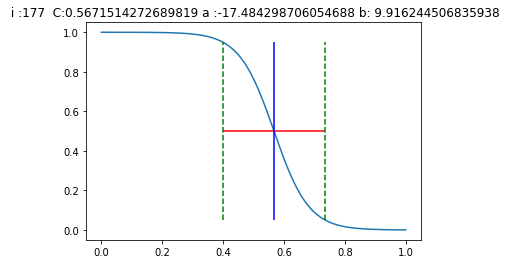

sigma :[5.6453744e-12]
Distance I.:0.6148002743721008
Distance x.:1.0
C :0.4298687279224396


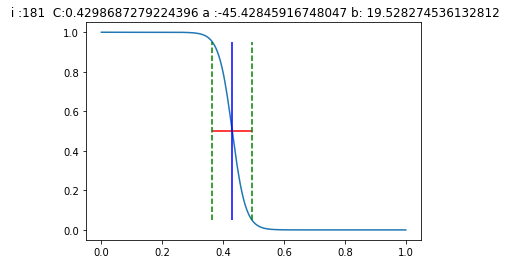

sigma :[3.8127983e-08]
Distance I.:0.8608186841011047
Distance x.:1.0
C :0.6048668622970581


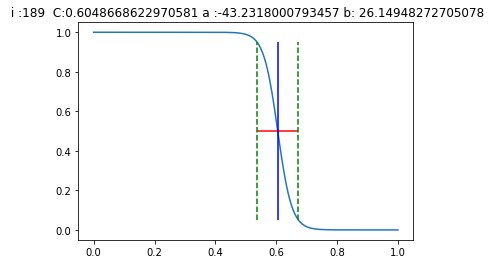

sigma :[0.00792359]
Distance I.:1.1389822959899902
Distance x.:1.0
C :0.7956891059875488


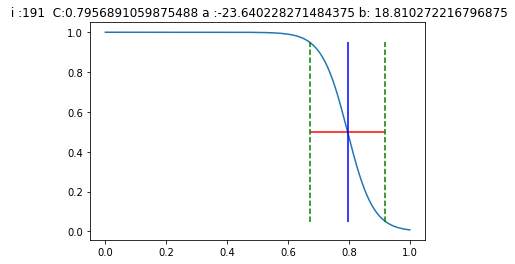

sigma :[0.98090935]
Distance I.:1.3045965433120728
Distance x.:1.0
C :0.9205761551856995


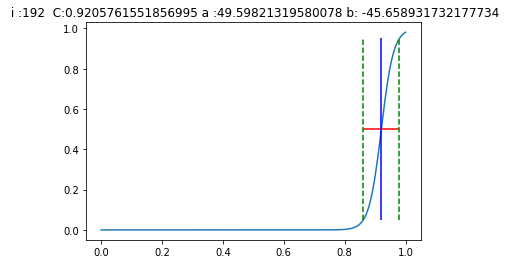

sigma :[0.9944787]
Distance I.:1.1238453388214111
Distance x.:1.0
C :0.7852975130081177


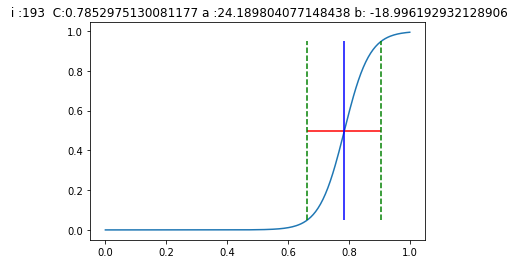

sigma :[1.]
Distance I.:0.32846134901046753
Distance x.:1.0
C :0.22115163505077362


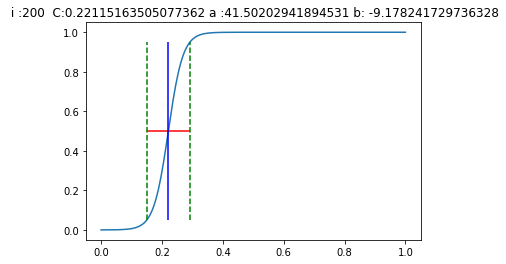

sigma :[0.00099941]
Distance I.:1.2313642501831055
Distance x.:1.0
C :0.8689103126525879


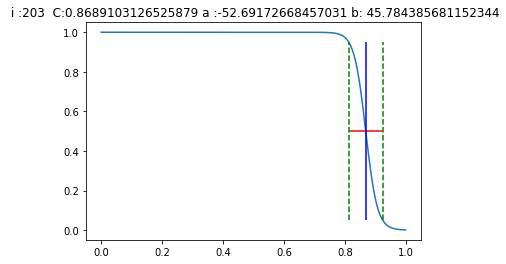

sigma :[0.99999774]
Distance I.:0.4267271161079407
Distance x.:1.0
C :0.2494140863418579


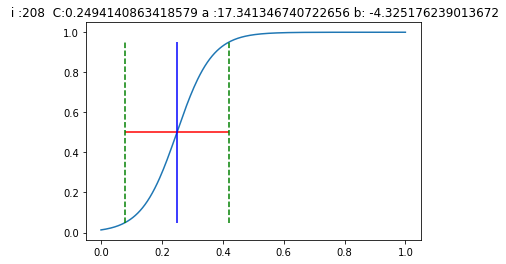

sigma :[0.9999988]
Distance I.:0.741844654083252
Distance x.:1.0
C :0.5139374732971191


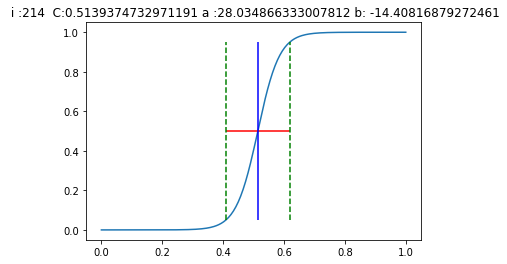

sigma :[0.00706517]
Distance I.:1.239249587059021
Distance x.:1.0
C :0.873012900352478


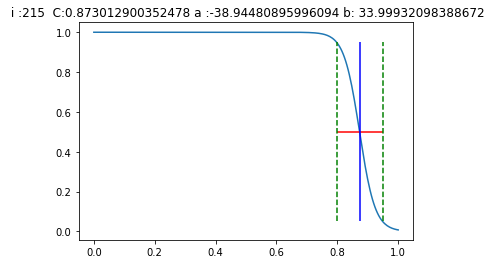

sigma :[0.0005912]
Distance I.:1.0685089826583862
Distance x.:1.0
C :0.7489748001098633


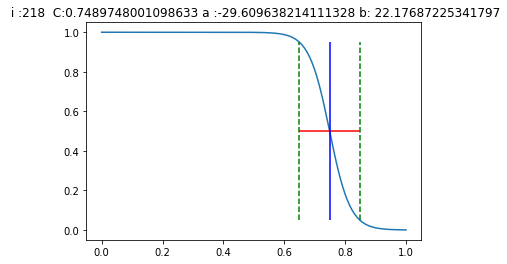

sigma :[1.]
Distance I.:0.7634924650192261
Distance x.:1.0
C :0.5335680246353149


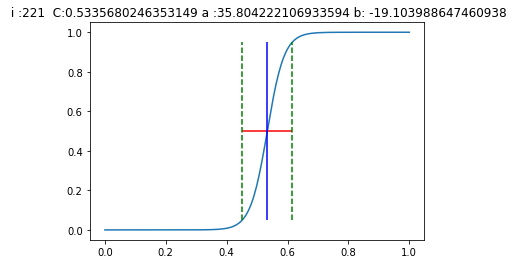

sigma :[1.]
Distance I.:0.42045101523399353
Distance x.:1.0
C :0.2804054021835327


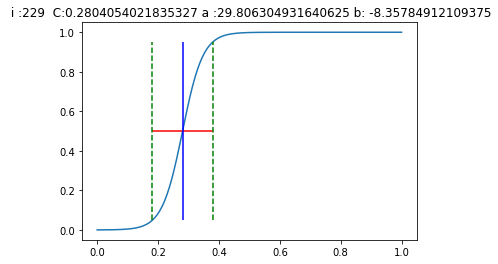

sigma :[0.9999989]
Distance I.:0.7930785417556763
Distance x.:1.0
C :0.5524992346763611


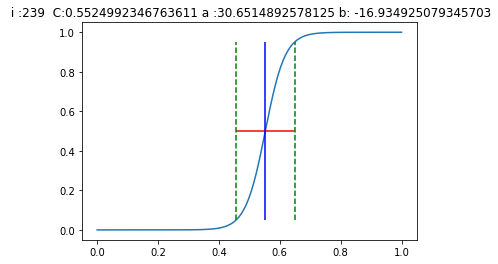

sigma :[1.]
Distance I.:0.582092821598053
Distance x.:1.0
C :0.40503421425819397


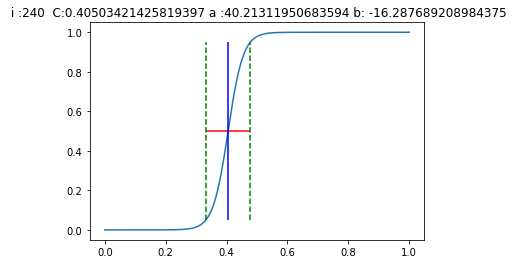

sigma :[0.00226148]
Distance I.:1.1867636442184448
Distance x.:1.0
C :0.8353837132453918


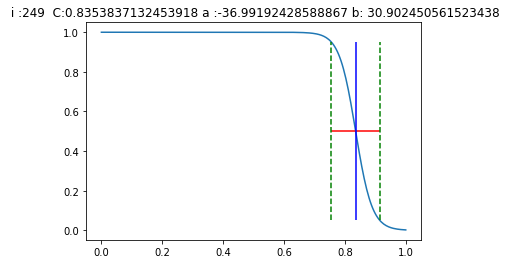

sigma :[0.01222321]
Distance I.:1.132992148399353
Distance x.:1.0
C :0.7884941697120667


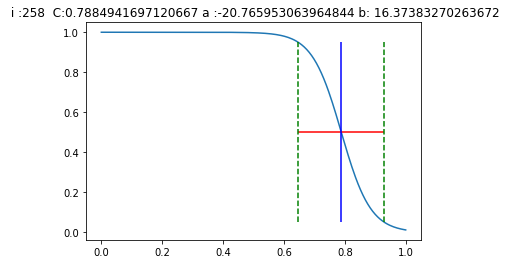

sigma :[0.9996376]
Distance I.:0.7888438105583191
Distance x.:1.0
C :0.5296918749809265


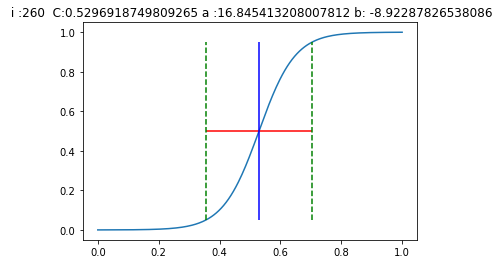

sigma :[0.9950465]
Distance I.:1.1311770677566528
Distance x.:1.0
C :0.7914310693740845


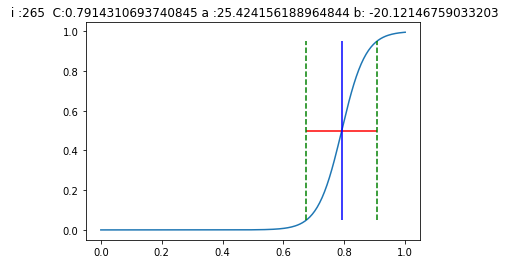

sigma :[0.78302956]
Distance I.:1.377201795578003
Distance x.:1.0
C :0.9716539978981018


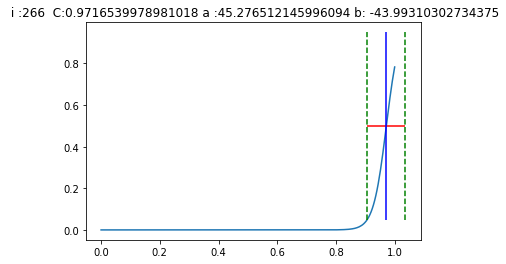

sigma :[7.3766714e-06]
Distance I.:1.0696849822998047
Distance x.:1.0
C :0.7538906335830688


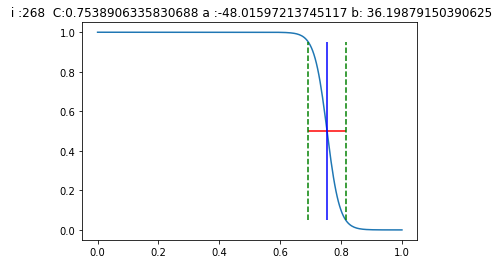

sigma :[0.58749664]
Distance I.:1.408007025718689
Distance x.:1.0
C :0.9769807457923889


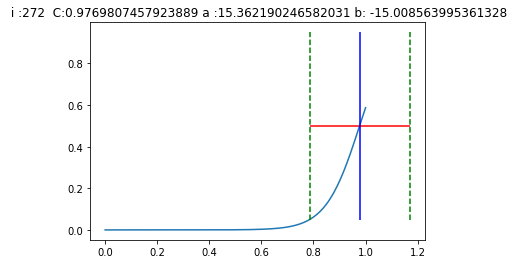

sigma :[0.03381636]
Distance I.:1.2984789609909058
Distance x.:1.0
C :0.9151313304901123


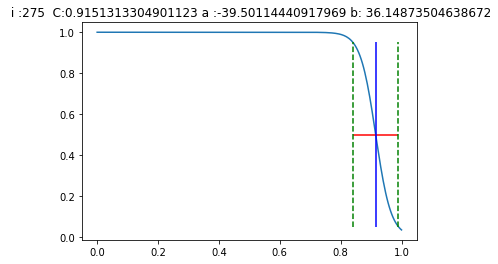

sigma :[0.99968016]
Distance I.:1.092284083366394
Distance x.:1.0
C :0.767667293548584


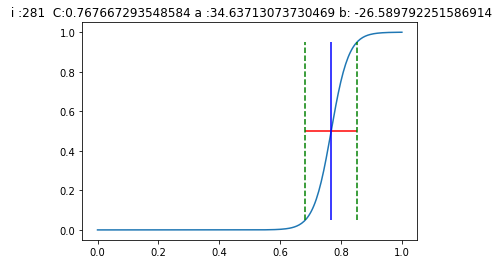

sigma :[0.989094]
Distance I.:1.058683156967163
Distance x.:1.0
C :0.7270501852035522


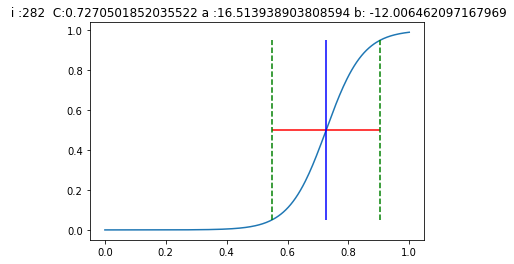

sigma :[0.9999999]
Distance I.:0.9464319348335266
Distance x.:1.0
C :0.6665804386138916


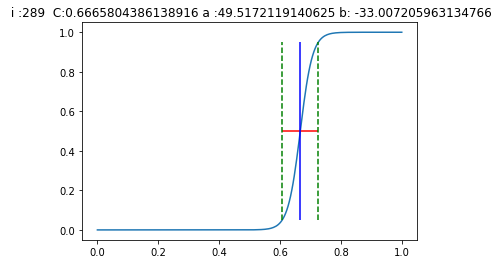

sigma :[4.1043227e-15]
Distance I.:0.43903863430023193
Distance x.:1.0
C :0.30422258377075195


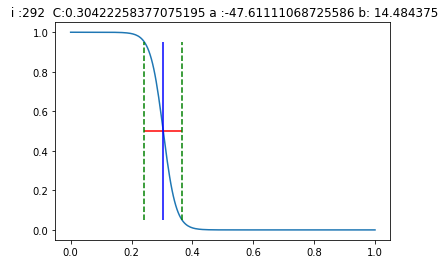

sigma :[0.9999994]
Distance I.:0.75885409116745
Distance x.:1.0
C :0.5278226733207703


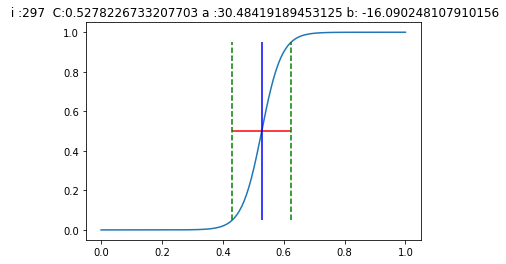

sigma :[0.15875632]
Distance I.:1.3710558414459229
Distance x.:1.0
C :0.9678150415420532


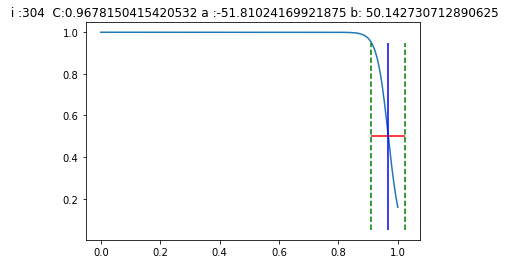

sigma :[1.]
Distance I.:0.13937559723854065
Distance x.:1.0
C :0.06679073721170425


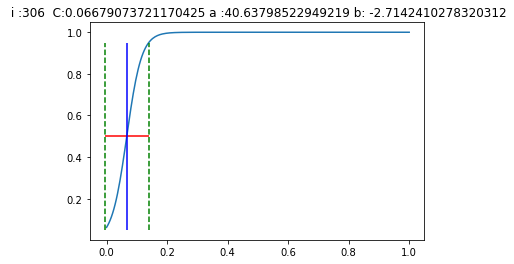

sigma :[3.1300885e-06]
Distance I.:0.989029586315155
Distance x.:1.0
C :0.6957676410675049


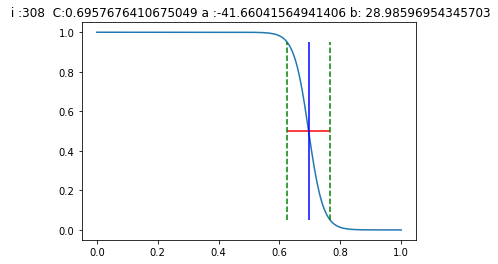

sigma :[0.00020086]
Distance I.:1.176633358001709
Distance x.:1.0
C :0.8299223184585571


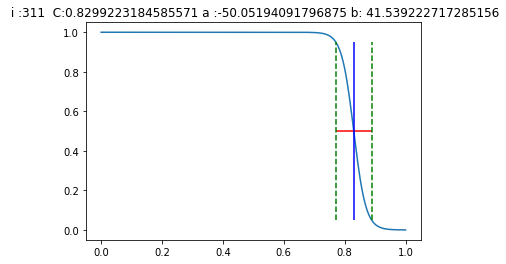

sigma :[1.4879244e-20]
Distance I.:0.09211788326501846
Distance x.:1.0
C :0.014073500409722328


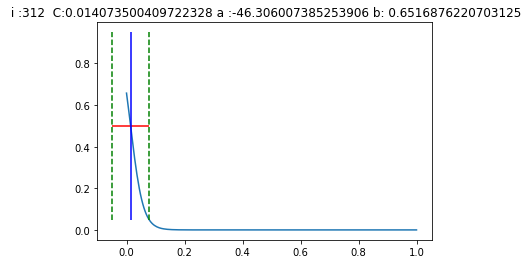

sigma :[0.4420098]
Distance I.:1.467182993888855
Distance x.:1.0
C :0.9711194634437561


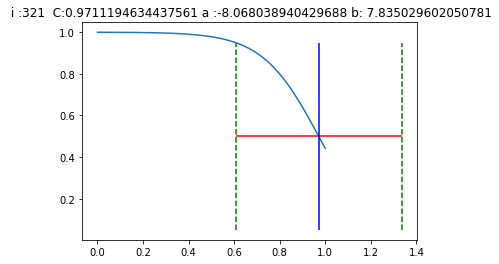

sigma :[0.9999999]
Distance I.:0.8883323073387146
Distance x.:1.0
C :0.6245794296264648


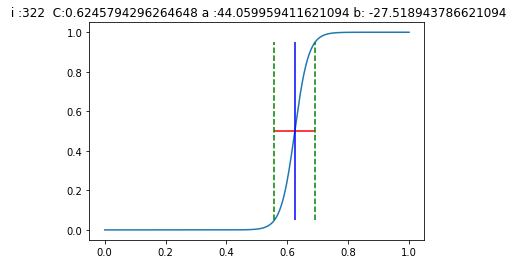

sigma :[4.44005e-06]
Distance I.:0.3359726369380951
Distance x.:1.0
C :0.10192230343818665


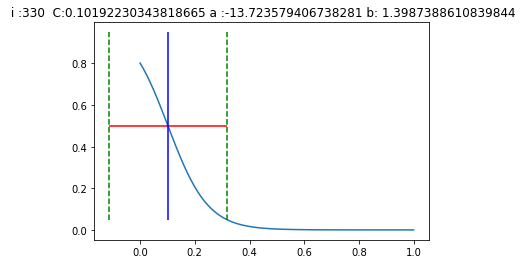

sigma :[0.9999999]
Distance I.:0.8688753247261047
Distance x.:1.0
C :0.6101586222648621


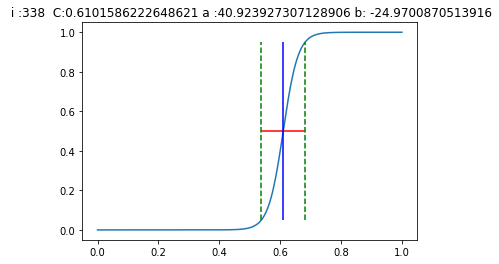

sigma :[1.]
Distance I.:0.13364951312541962
Distance x.:1.0
C :0.037645209580659866


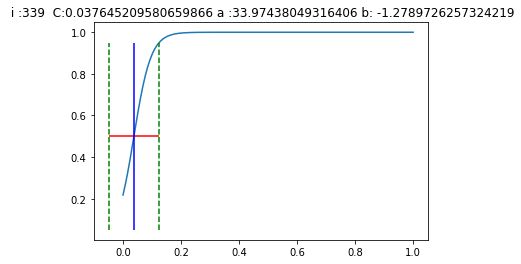

sigma :[0.9997707]
Distance I.:0.7907201647758484
Distance x.:1.0
C :0.5346760153770447


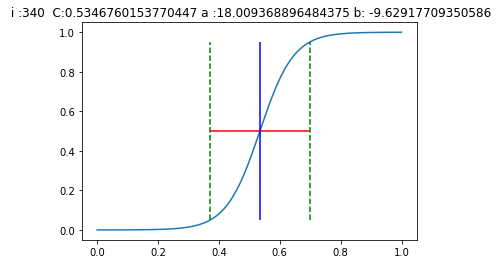

sigma :[0.9885438]
Distance I.:1.2892544269561768
Distance x.:1.0
C :0.9096859097480774


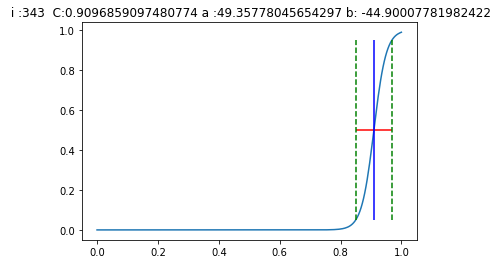

sigma :[0.9987447]
Distance I.:0.8430537581443787
Distance x.:1.0
C :0.5643299221992493


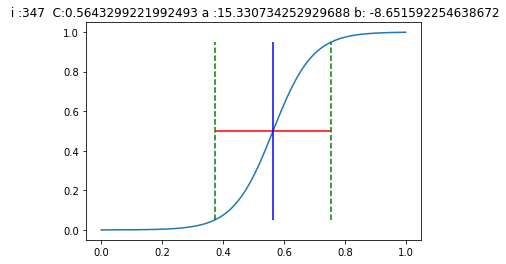

sigma :[1.]
Distance I.:0.162299245595932
Distance x.:1.0
C :0.0839119479060173


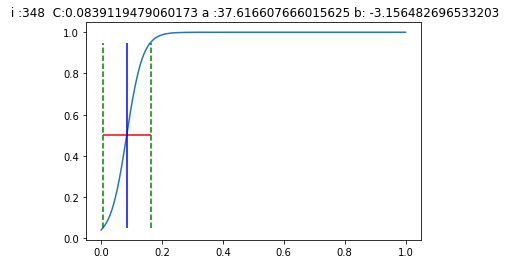

sigma :[6.141808e-18]
Distance I.:0.35606643557548523
Distance x.:1.0
C :0.24545428156852722


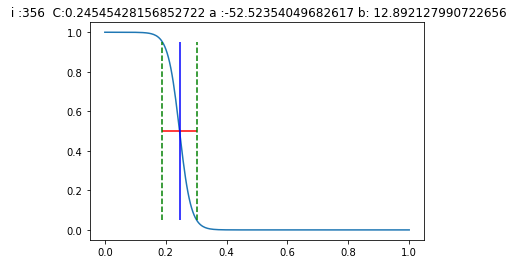

sigma :[0.00946062]
Distance I.:1.283271074295044
Distance x.:1.0
C :0.905431866645813


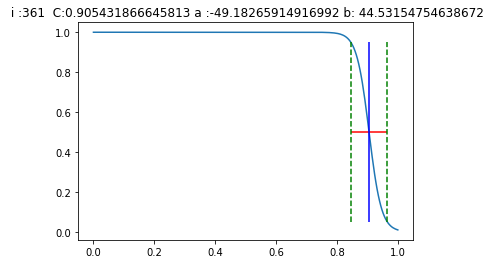

sigma :[1.]
Distance I.:0.25966036319732666
Distance x.:1.0
C :0.15583299100399017


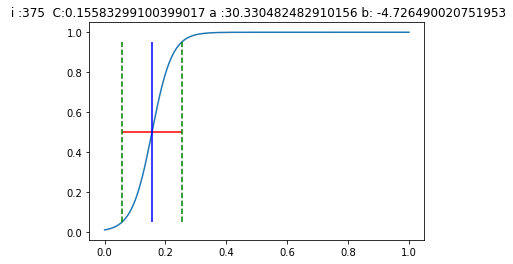

sigma :[7.0929955e-06]
Distance I.:1.0891382694244385
Distance x.:1.0
C :0.7679776549339294


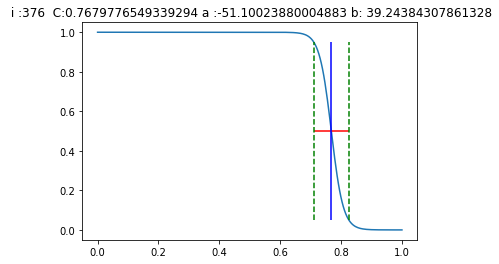

sigma :[0.88499236]
Distance I.:1.3361777067184448
Distance x.:1.0
C :0.9409717917442322


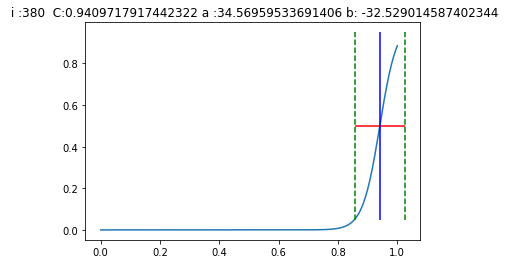

sigma :[0.07396547]
Distance I.:1.0882772207260132
Distance x.:1.0
C :0.49276959896087646


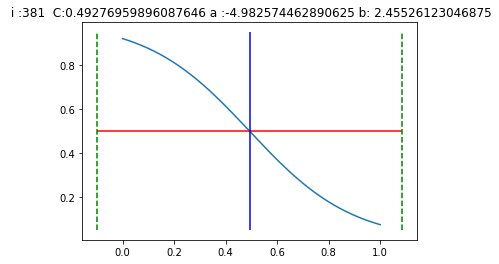

sigma :[0.00066319]
Distance I.:1.1977282762527466
Distance x.:1.0
C :0.8446098566055298


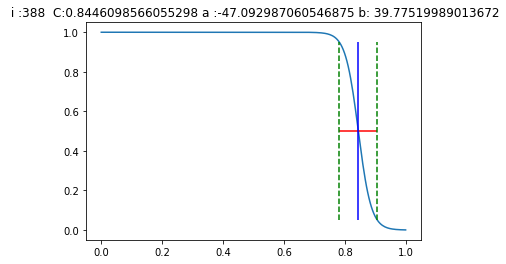

sigma :[2.0710754e-10]
Distance I.:0.5588323473930359
Distance x.:1.0
C :0.3867645859718323


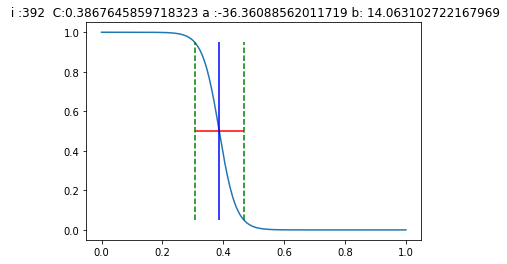

sigma :[0.66963094]
Distance I.:1.386526346206665
Distance x.:1.0
C :0.9163951873779297


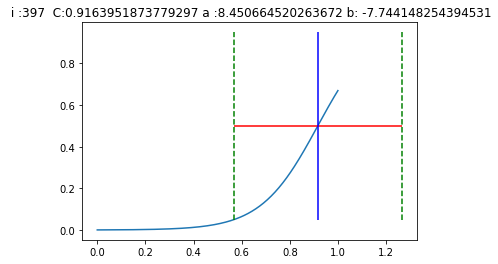

sigma :[3.292524e-22]
Distance I.:0.12201184034347534
Distance x.:1.0
C :0.06596223264932632


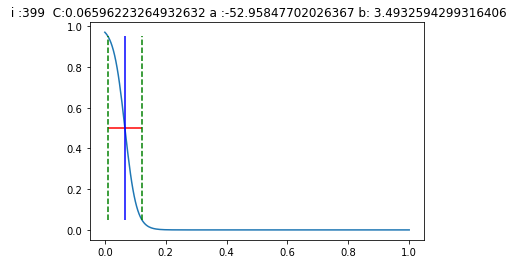

sigma :[1.]
Distance I.:0.3619208335876465
Distance x.:1.0
C :0.24527296423912048


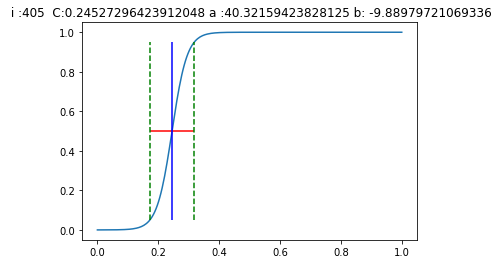

sigma :[0.01507155]
Distance I.:1.1273677349090576
Distance x.:1.0
C :0.7822686433792114


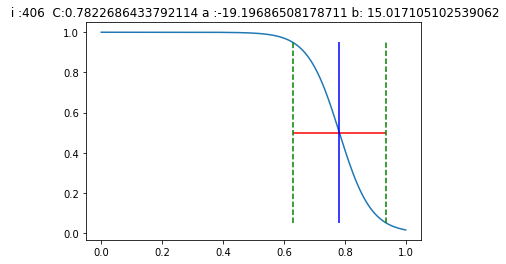

sigma :[0.8599484]
Distance I.:1.2853436470031738
Distance x.:1.0
C :0.8917335867881775


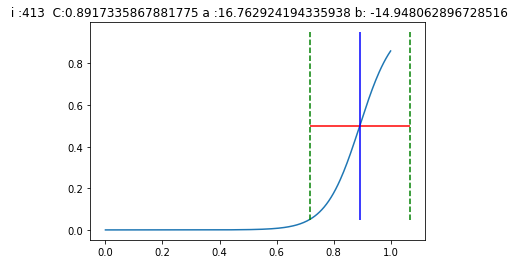

sigma :[5.591523e-09]
Distance I.:0.2179861217737198
Distance x.:1.0
C :0.04064347594976425


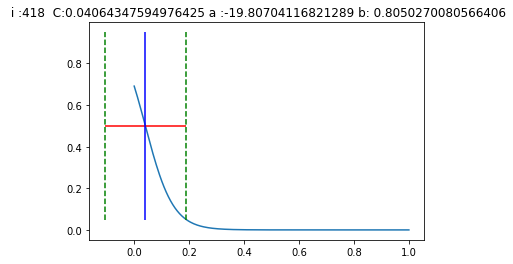

sigma :[9.3967414e-05]
Distance I.:1.0475504398345947
Distance x.:1.0
C :0.7359678745269775


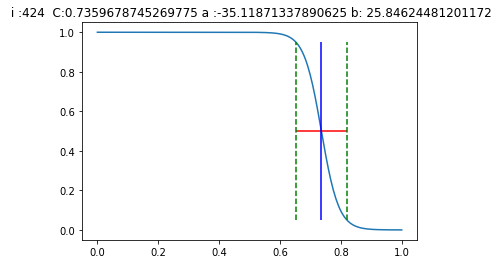

sigma :[0.99971646]
Distance I.:0.9766771793365479
Distance x.:1.0
C :0.680968165397644


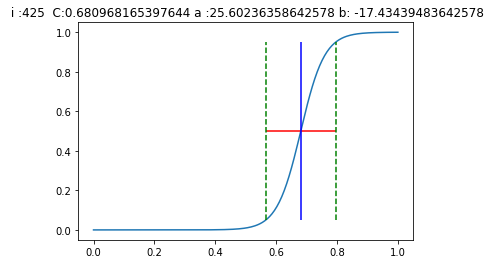

sigma :[4.4028257e-06]
Distance I.:1.0012803077697754
Distance x.:1.0
C :0.7044869065284729


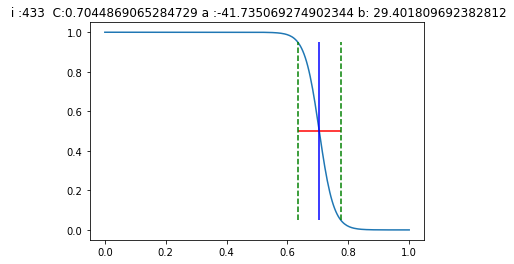

sigma :[0.9999975]
Distance I.:0.7225833535194397
Distance x.:1.0
C :0.4979401230812073


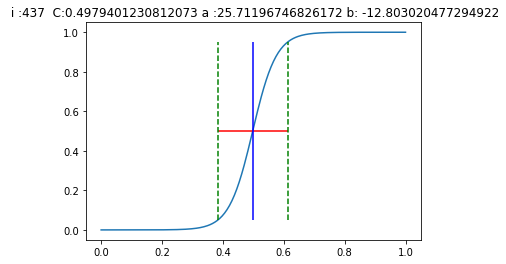

sigma :[0.9999999]
Distance I.:0.7710363864898682
Distance x.:1.0
C :0.5387786626815796


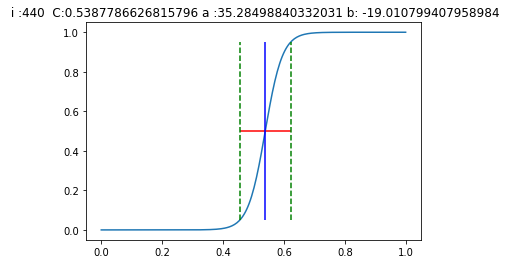

sigma :[1.]
Distance I.:0.3051142990589142
Distance x.:1.0
C :0.20230792462825775


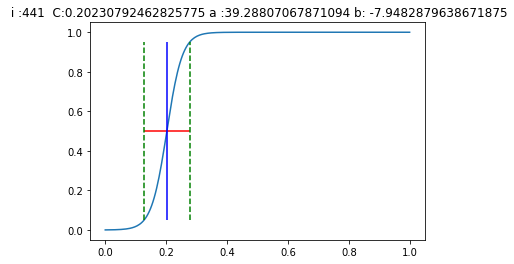

sigma :[1.]
Distance I.:0.5646218657493591
Distance x.:1.0
C :0.3932342529296875


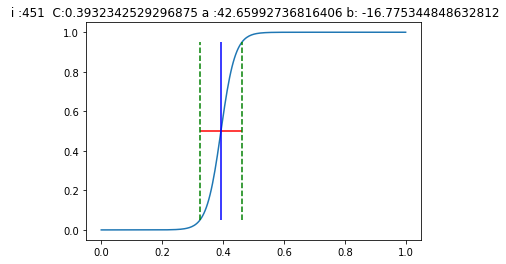

sigma :[1.5461869e-21]
Distance I.:0.12802477180957794
Distance x.:1.0
C :0.07021258771419525


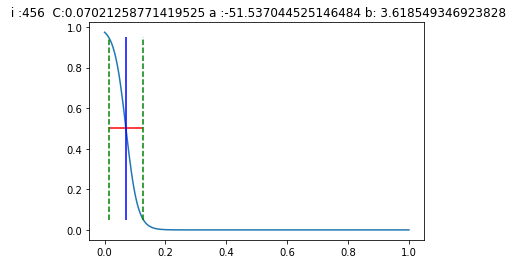

sigma :[0.05133257]
Distance I.:1.3190370798110962
Distance x.:1.0
C :0.9300197958946228


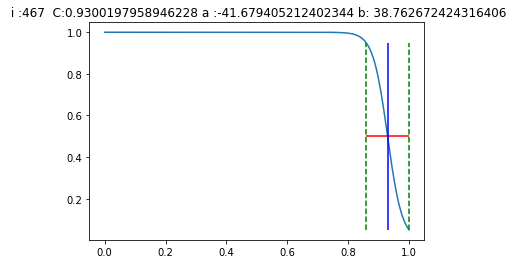

sigma :[1.2122334e-12]
Distance I.:0.6706130504608154
Distance x.:1.0
C :0.47078076004981995


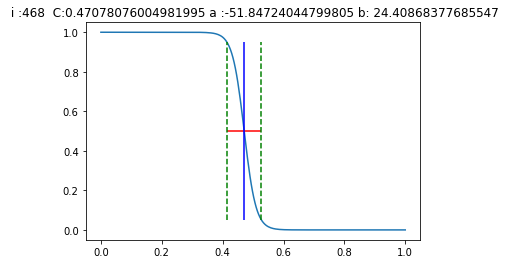

sigma :[0.07189707]
Distance I.:1.2779392004013062
Distance x.:1.0
C :0.8956113457679749


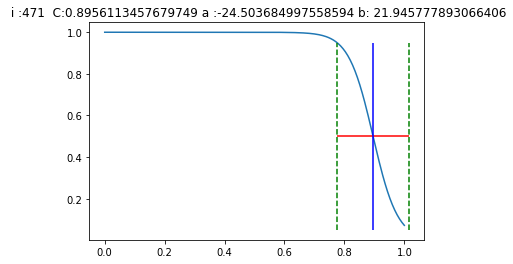

sigma :[0.9999999]
Distance I.:0.6381493210792542
Distance x.:1.0
C :0.4399963617324829


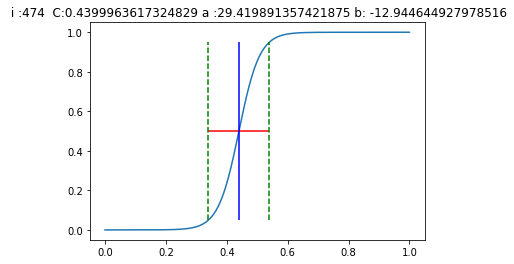

sigma :[1.]
Distance I.:0.3025989830493927
Distance x.:1.0
C :0.20116901397705078


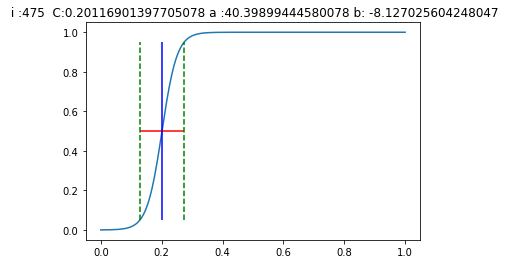

sigma :[0.99904627]
Distance I.:1.1003656387329102
Distance x.:1.0
C :0.7720653414726257


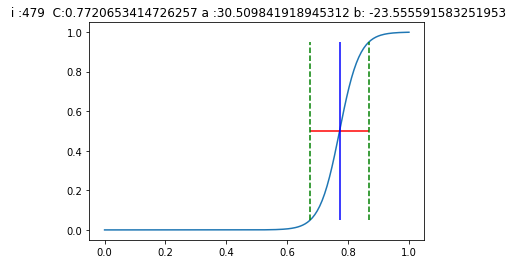

sigma :[1.7265395e-16]
Distance I.:0.33813029527664185
Distance x.:1.0
C :0.23080448806285858


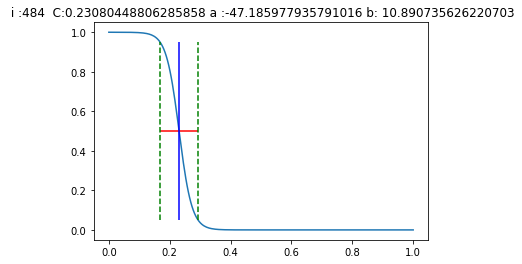

sigma :[0.00184889]
Distance I.:1.2147572040557861
Distance x.:1.0
C :0.8563260436058044


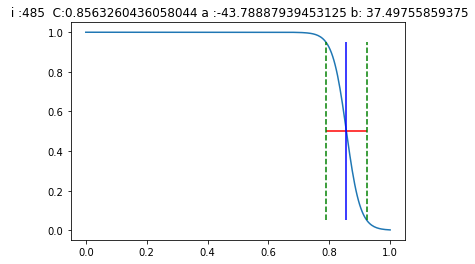

sigma :[4.5863767e-06]
Distance I.:0.36653244495391846
Distance x.:1.0
C :0.1646953821182251


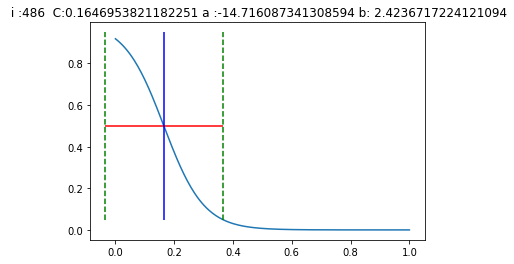

sigma :[2.3869616e-16]
Distance I.:0.1259363442659378
Distance x.:1.0
C :0.042201485484838486


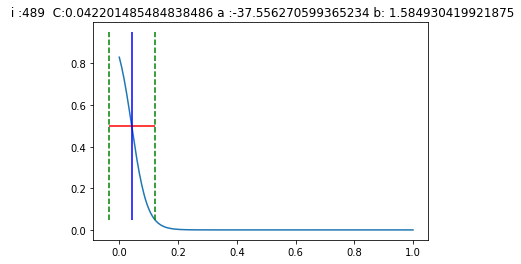

sigma :[1.]
Distance I.:0.30752575397491455
Distance x.:1.0
C :0.20792940258979797


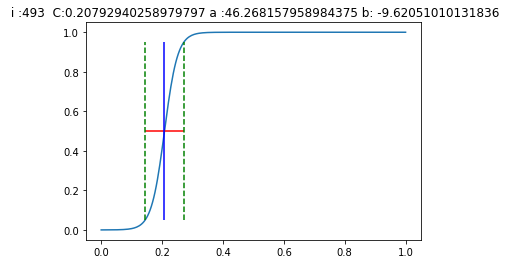

sigma :[2.6078778e-10]
Distance I.:0.6843892931938171
Distance x.:1.0
C :0.47891366481781006


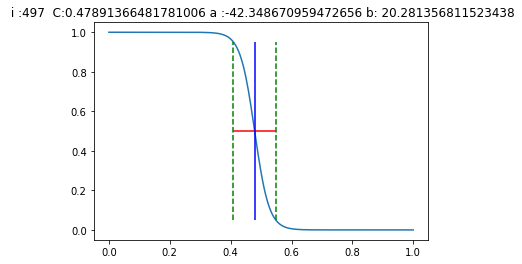

sigma :[0.99999654]
Distance I.:0.7760292887687683
Distance x.:1.0
C :0.5379624366760254


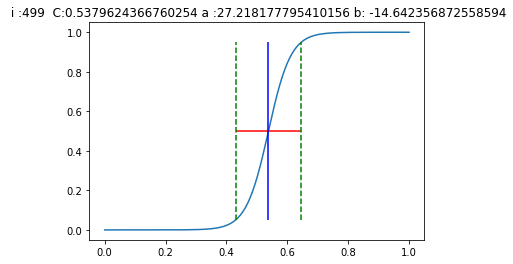

In [34]:
good_alpha = []
good_beta = []
C_good = []
counter = 0
for i in tnrange(len(alpha)):
    value = (2.945)/alpha[i]
    low = C[i] - value
    high = C[i] + value
    
    distance_I = tf.norm(tf.constant(np.array([low,high]), tf.float32))
    distance_x = tf.norm(tf.constant(np.array([x[0],x[-1]]), tf.float32))

        
#     isclose = np.isclose(distance_I, distance_x)
#     if distance_I < distance_x or isclose:
#     if low > 0 and high > 0:
#     if low > 0 and high > 0:

#     if (low >= x[0] and high > x[0]):
#         if x[0]<low and x[-1]> high: 
#             if alpha[i]>0.0:
#                 counter += 1
#     print('counter',i)
#     print(f'{x[0]} < {low}')
#     print(f'{x[-1]} > {high}')
#     if alpha[i] > 0.:
    if C[i] > x[0]  and C[i] <x[-1]:
        counter +=1
        good_alpha.append(alpha[i])
        good_beta.append(beta[i])
        C_good.append(C[i])     
        print(f'sigma :{sigma(x,alpha[i], beta[i])[-1]}')
        print(f'Distance I.:{distance_I}')
        print(f'Distance x.:{distance_x}')
#         print(f'Is close :{np.isclose(sigma(C[i],alpha[i], beta[i]),0.5)}')
        print(f'C :{C[i]}')
        plt.plot(x,sigma(x,alpha[i], beta[i]))
        plt.hlines(y = sigma(C[i],alpha[i], beta[i]),xmin= low, xmax=high, colors='red', linestyles='-')
        plt.vlines(x = C[i], ymin=0.05, ymax= 0.95,colors='b', linestyles='-')
        plt.vlines(x = low, ymin=0.05, ymax= 0.95,colors='g', linestyles='--')
        plt.vlines(x = high, ymin=0.05, ymax= 0.95,colors='g', linestyles='--')        

        plt.title(f' i :{i}  C:{C[i]} a :{alpha[i]} b: {beta[i]}')
        plt.show()


In [6]:
counter,good_alpha, good_beta  = calc_alpha_beta(alpha,beta,C)
counter

  0%|          | 0/300 [00:00<?, ?it/s]

69

Residue Norm  : 0.00961204431951046
Residue mse  : 2.7173937269253656e-06
Error : 7.160862445831299
mse Error  : 0.34185299277305603


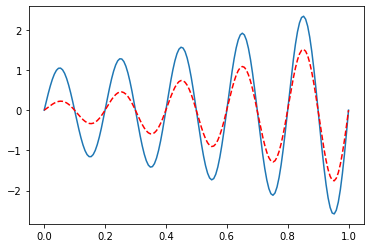

In [7]:
# C_best = test(C_good)
# beta = -C_best*alpha
neurons = len(good_beta)

M = neurons//2
alpha = tf.convert_to_tensor(good_alpha,tf.float32)
beta = tf.convert_to_tensor(good_beta,tf.float32)

x_m_minus_2 = tf.linspace(x[1],x[-2],M-2)
k = 5.
S0,S1,S2 = S_matrices(x_m_minus_2,alpha,beta)
int_array = tf.concat([x[0],x[-1]],axis=0)[:,None]
B0,B1 = B_matrices(int_array,alpha,beta)

fg = np.zeros((M,1))
SB_matrix = np.zeros((M,neurons))
lhs_eqn = S2 + (4.*tf.pow(k*np.pi,2) - 1.)*S0
rhs_eqn = 4.*k*np.pi*tf.math.exp(x_m_minus_2)*tf.math.cos(2.*k*np.pi*x_m_minus_2)

lhs_BC =  B0
rhs_BC =  tf.zeros((2,1))
# 

# First row == B0[0]
SB_matrix[0] = lhs_BC[0]
# Last row == B0[-1]
SB_matrix[-1] = lhs_BC[-1]
# inbetween == rhs_eqn
SB_matrix[1:-1] = lhs_eqn

# FG matrix
# First row == B0[0]
fg[0] = rhs_BC[0]
# Last row == B0[-1]
fg[-1] = rhs_BC[-1]
# inbetween == rhs_eqn
fg[1:-1] = rhs_eqn

weight = tf.linalg.pinv(SB_matrix)@fg
weight = tf.cast(weight, tf.float32)
u_hat = sigma(x, alpha, beta)@weight
u = lambda x: tf.math.exp(x)*tf.math.sin(2.*k*np.pi*x)
error = tf.norm(u_hat- u(x))
mse = tf.reduce_mean(tf.square(u_hat- u(x)))
residue = SB_matrix@weight - fg
res_nrom = tf.norm(residue)
res_mse = tf.reduce_mean(tf.square(residue))
print(f'Residue Norm  : {res_nrom}')
print(f'Residue mse  : {res_mse}')
print(f'Error : {tf.norm(error)}') 
print(f'mse Error  : {mse}')
plt.plot(x,u(x))
plt.plot(x,u_hat, 'r--')
# plt.xlim(0.4)
# plt.ylim(-50.,50.)
plt.show()              
                

In [23]:
Residue Norm  : 8.761048229644075e-05
Residue mse  : 7.675596824796571e-10
Error : 0.16605976223945618
mse Error  : 0.0006725815474055707

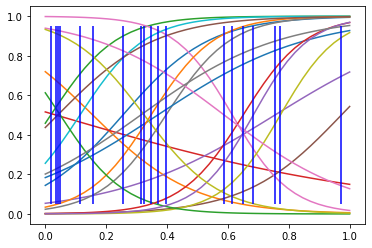

In [24]:
plt.plot(x,sigma(x,tf.convert_to_tensor(good_alpha,tf.float32),tf.convert_to_tensor(good_beta,tf.float32)))
plt.vlines(x = tf.convert_to_tensor(C_good,tf.float32), ymin=0.05, ymax= 0.95,colors='b', linestyles='-')
plt.show()

Residue Norm  : 3.568339525372721e-05
Residue mse  : 1.4147830129651595e-10
Error : 5.488987922668457
mse Error  : 0.7532247304916382


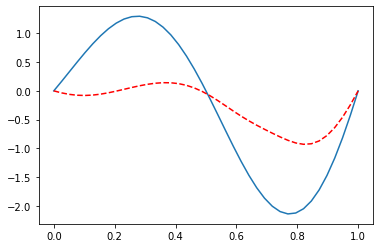

In [25]:
# C_best = test(C_good)
# beta = -C_best*alpha
neurons = len(good_beta)
M = neurons//2
alpha = tf.convert_to_tensor(good_alpha,tf.float32)
beta = tf.convert_to_tensor(good_beta,tf.float32)
C_best = C_good[0]

x_m_minus_2 = tf.linspace(x[1],x[-2],M-2)
k = 1.
S0,S1,S2 = S_matrices(x_m_minus_2,alpha,beta)
int_array = tf.concat([x[0],x[-1]],axis=0)[:,None]
B0,B1 = B_matrices(int_array,alpha,beta)

fg = np.zeros((M,1))
SB_matrix = np.zeros((M,neurons))
lhs_eqn = S2 + (4.*tf.pow(k*np.pi,2) - 1.)*S0
rhs_eqn = 4.*k*np.pi*tf.math.exp(x_m_minus_2)*tf.math.cos(2.*k*np.pi*x_m_minus_2)

lhs_BC =  B0
rhs_BC =  tf.zeros((2,1))
# 

# First row == B0[0]
SB_matrix[0] = lhs_BC[0]
# Last row == B0[-1]
SB_matrix[-1] = lhs_BC[-1]
# inbetween == rhs_eqn
SB_matrix[1:-1] = lhs_eqn

# FG matrix
# First row == B0[0]
fg[0] = rhs_BC[0]
# Last row == B0[-1]
fg[-1] = rhs_BC[-1]
# inbetween == rhs_eqn
fg[1:-1] = rhs_eqn

weight = tf.linalg.pinv(SB_matrix)@fg
weight = tf.cast(weight, tf.float32)
u_hat = sigma(x, alpha, beta)@weight
u = lambda x: tf.math.exp(x)*tf.math.sin(2.*k*np.pi*x)
error = tf.norm(u_hat- u(x))
mse = tf.reduce_mean(tf.square(u_hat- u(x)))
residue = SB_matrix@weight - fg
res_nrom = tf.norm(residue)
res_mse = tf.reduce_mean(tf.square(residue))
print(f'Residue Norm  : {res_nrom}')
print(f'Residue mse  : {res_mse}')
print(f'Error : {tf.norm(error)}') 
print(f'mse Error  : {mse}')
plt.plot(x,u(x))
plt.plot(x,u_hat, 'r--')
# plt.xlim(0.4)
# plt.ylim(-50.,50.)
plt.show()              
                

In [ ]:
# neurons = counter
# M = neurons//2
neurons,M

uniform_int_alpha_new = tf.initializers.RandomUniform(minval=va_min, maxval=va_max,seed=1)
# uniform_int_beta = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=2)


alpha_new= uniform_int_alpha_new(shape=(neurons,))
beta_new = -C_good[0]*alpha_new

def test(C_good):
    best_error = np.inf
    for C in C_good:
        beta = -C*alpha
        x_m_minus_2 = tf.linspace(x[1],x[-2],M-2)
        k = 1.
        S0,S1,S2 = S_matrices(x_m_minus_2,alpha,beta)
        int_array = tf.concat([x[0],x[-1]],axis=0)[:,None]
        B0,B1 = B_matrices(int_array,alpha,beta)

        fg = np.zeros((M,1))
        SB_matrix = np.zeros((M,neurons))
        lhs_eqn = S2 + (4.*tf.pow(k*np.pi,2) - 1.)*S0
        rhs_eqn = 4.*k*np.pi*tf.math.exp(x_m_minus_2)*tf.math.cos(2.*k*np.pi*x_m_minus_2)

        lhs_BC =  B0
        rhs_BC =  tf.zeros((2,1))
        # 

        # First row == B0[0]
        SB_matrix[0] = lhs_BC[0]
        # Last row == B0[-1]
        SB_matrix[-1] = lhs_BC[-1]
        # inbetween == rhs_eqn
        SB_matrix[1:-1] = lhs_eqn

        # FG matrix
        # First row == B0[0]
        fg[0] = rhs_BC[0]
        # Last row == B0[-1]
        fg[-1] = rhs_BC[-1]
        # inbetween == rhs_eqn
        fg[1:-1] = rhs_eqn

        weight = tf.linalg.pinv(SB_matrix)@fg
        weight = tf.cast(weight, tf.float32)
        u_hat = sigma(x, alpha, beta)@weight
        u = lambda x: tf.math.exp(x)*tf.math.sin(2.*k*np.pi*x)
        error = tf.norm(u_hat- u(x))
        residue = SB_matrix@weight - fg
        res_nrom = tf.norm(residue)
        res_mse = tf.reduce_mean(tf.square(residue))
        if error < best_error:
            if C>0:
                print(f'Residue Norm  : {res_nrom}')
                print(f'Residue mse  : {res_mse}')
                print(f'Error : {tf.norm(error)}') 
                best_error = error
                C_best = C
                print(f'C     : {C}\n')  
                
    return C_best       